In [7]:
import numpy as np
import pandas as pd
import pandahouse as ph
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230420',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# Отбираем данные за нужные даты по группам 2,3
query = '''
SELECT
user_id,
SUM(action='like')/SUM(action='view') AS ctr,
exp_group
FROM simulator_20230420.feed_actions
WHERE exp_group in (2, 3)
AND (toDate(time) BETWEEN '2023-03-25' AND '2023-03-31')
GROUP BY user_id,exp_group
'''



In [3]:
# записываем в датафрейм
aa_exp = ph.read_clickhouse(query, connection=connection)

In [13]:
aa_exp.head(5)

,user_id,ctr,exp_group
0,115383,0.305556,3
1,123580,0.163043,3
2,131473,0.175676,2
3,23985,0.181818,2
4,24523,0.141667,2


In [10]:
p_values=[]
iterations = 10000
for _ in range(iterations):
    sample_2 = aa_exp.query('exp_group==2').ctr.sample(500, replace=False).tolist()
    sample_3 = aa_exp.query('exp_group==3').ctr.sample(500, replace=False).tolist()
    p_values.append(stats.ttest_ind(sample_2, sample_3, equal_var = False)[1]) # проводим т-тест и записываем p_value по каждому эксперименту в список


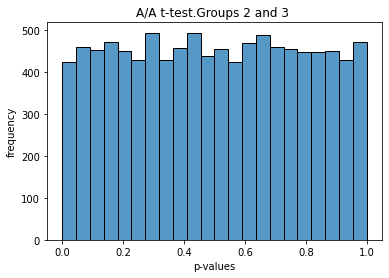

In [11]:
# рисуем гистограмму распределения p_value. Видно, что распределение получилось равномерным, т.е. сплитование на группы 2 и 3 прошло успешно, группы одинаковые
sns.histplot(p_values)
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("A/A t-test.Groups 2 and 3 ")
plt.show()

In [12]:
# Проверяем, что количество ложноположительных случаев  не превышает альфа. В нашей выборке меньше 5% ложноположительных случаев,тест пройден.
sum(np.array(p_values) <0.05) / iterations

0.0478

Можно сделать следующие выводы:
Система сплитования работает хорошо, распределение p_value т-теста между двумя группами равномерно.
Менее, чем в 5% случаев тест показывает значимую разницу ctr между группами 2 и 3, таким образом мы принимаем нулевую гипотезу о том, что между группами 2 и 3 нет статистически значимой разницы. А/А тест пройден.